In [2]:
# Install dependencies (run this cell once if you haven't already)
%pip install torch torchvision pandas matplotlib seaborn scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set device
# Check for CUDA (NVIDIA), then MPS (Mac), then CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [13]:
def get_transforms(split="train"):
    if split == "train":
        return torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.RandomRotation(5),  
            torchvision.transforms.ColorJitter(brightness=0.05),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        return torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [14]:
train_dir = 'data/chestx-ray/train'
test_dir = 'data/chestx-ray/test'

print("Loading datasets...")
trainset = ImageFolder(root=train_dir, transform=get_transforms("train"))
testset = ImageFolder(root=test_dir, transform=get_transforms("test"))

class_names = trainset.classes
print(f"Classes: {class_names}")
print(f"Train size: {len(trainset)}, Test size: {len(testset)}")

BATCH_SIZE = 32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

Loading datasets...
Classes: ['normal', 'pneumonia', 'tuberculosis']
Train size: 20450, Test size: 2569


In [16]:
from collections import Counter
train_labels = [label for _, label in trainset]
print("Training set distribution:", Counter(train_labels))
test_labels = [label for _, label in testset]
print("Test set distribution:", Counter(test_labels))

Training set distribution: Counter({2: 8513, 0: 7263, 1: 4674})
Test set distribution: Counter({2: 1064, 0: 925, 1: 580})


In [17]:
def model_arch(num_classes):
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model = model_arch(num_classes=len(class_names)).to(device)

In [18]:
def train_model(model, trainloader, testloader, criterion, optimizer, device, num_epochs=5):
    train_losses = []
    test_accuracies = []
    
    print("Starting Training...")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in trainloader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(trainloader)
        accuracy, _, _ = evaluate(model, testloader, device)
        
        train_losses.append(epoch_loss)
        test_accuracies.append(accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Test Acc: {accuracy*100:.2f}%")
        
    return train_losses, test_accuracies

def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = (all_preds == all_labels).mean()
    
    return accuracy, all_labels, all_preds

In [19]:
def plot_results(train_losses, test_accuracies, all_labels, all_preds, class_names):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Loss & Accuracy
    ax[0].plot(train_losses, label='Training Loss', color='tab:orange', linewidth=2)
    ax[0].set_ylabel('Loss', color='tab:orange')
    ax2 = ax[0].twinx()
    ax2.plot(test_accuracies, label='Test Accuracy', color='tab:blue', linewidth=2)
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax[0].set_title("Training Dynamics")
    ax[0].set_xlabel("Epochs")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[1],
                xticklabels=class_names, yticklabels=class_names)
    ax[1].set_title("Confusion Matrix")
    ax[1].set_ylabel("Actual")
    ax[1].set_xlabel("Predicted")
    
    plt.tight_layout()
    plt.show()

Starting Training...
Epoch 1/20 | Loss: 0.4294 | Test Acc: 72.56%
Epoch 2/20 | Loss: 0.3871 | Test Acc: 77.15%
Epoch 3/20 | Loss: 0.3845 | Test Acc: 68.98%
Epoch 4/20 | Loss: 0.3829 | Test Acc: 76.18%
Epoch 5/20 | Loss: 0.3777 | Test Acc: 74.89%
Epoch 6/20 | Loss: 0.3726 | Test Acc: 77.38%
Epoch 7/20 | Loss: 0.3771 | Test Acc: 76.45%
Epoch 8/20 | Loss: 0.3754 | Test Acc: 77.54%
Epoch 9/20 | Loss: 0.3788 | Test Acc: 77.66%
Epoch 10/20 | Loss: 0.3633 | Test Acc: 77.50%
Epoch 11/20 | Loss: 0.3633 | Test Acc: 77.66%
Epoch 12/20 | Loss: 0.3626 | Test Acc: 77.03%
Epoch 13/20 | Loss: 0.3727 | Test Acc: 77.54%
Epoch 14/20 | Loss: 0.3679 | Test Acc: 77.66%
Epoch 15/20 | Loss: 0.3769 | Test Acc: 77.50%
Epoch 16/20 | Loss: 0.3656 | Test Acc: 75.05%
Epoch 17/20 | Loss: 0.3693 | Test Acc: 77.27%
Epoch 18/20 | Loss: 0.3593 | Test Acc: 77.54%
Epoch 19/20 | Loss: 0.3706 | Test Acc: 77.23%
Epoch 20/20 | Loss: 0.3653 | Test Acc: 77.73%
Final Test Accuracy: 77.73%


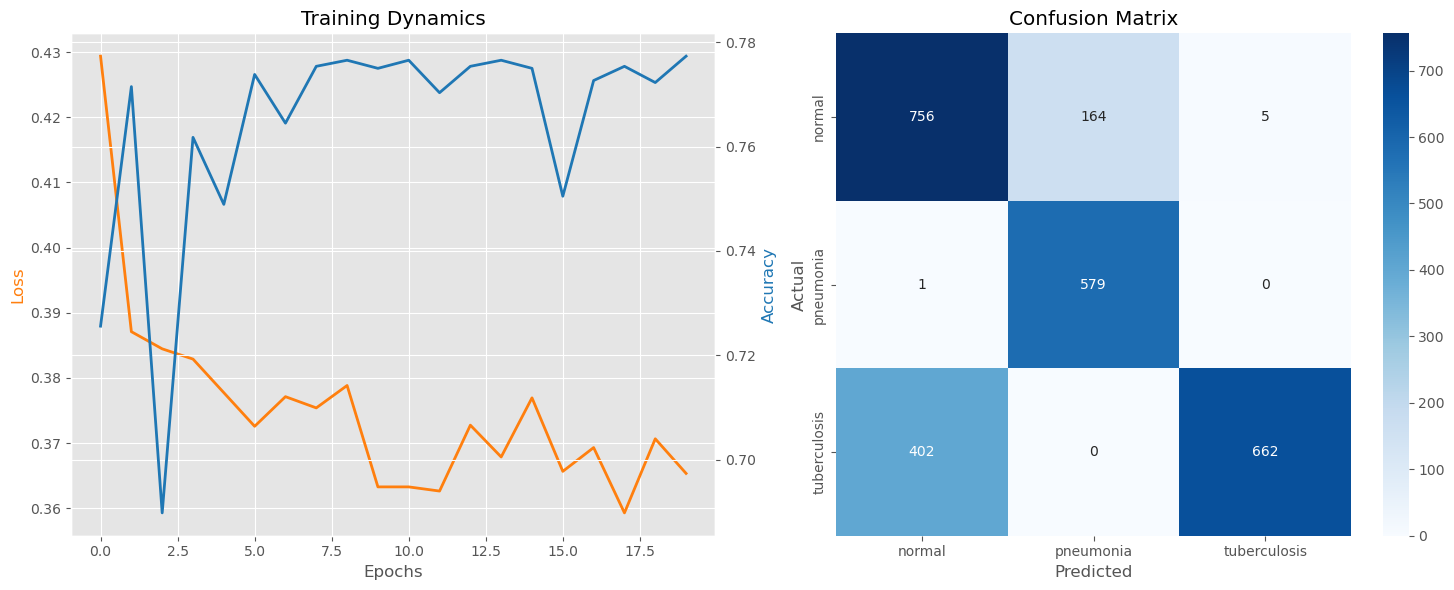

In [20]:

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

losses, accuracies = train_model(model, trainloader, testloader, criterion, optimizer, device, num_epochs=20)

final_acc, labels, preds = evaluate(model, testloader, device)
print(f"Final Test Accuracy: {final_acc*100:.2f}%")

plot_results(losses, accuracies, labels, preds, class_names)